Importando bibliotecas necessárias para o modelo de XGBoost Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import pickle

Lendo arquivo .csv (Synthetic_Financial_datasets_log)

In [2]:
df = pd.read_csv("Synthetic_Financial_datasets_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Realizando limpeza de valores nulos

In [3]:
df = df.dropna(subset=[
    'step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest', 'isFraud'
])
df.shape

(6362620, 11)

Codificando variáveis categóricas

In [4]:
le_type = LabelEncoder()
df['type_encoded'] = le_type.fit_transform(df['type'])

Criando variáveis derivadas

In [5]:
df['deltaOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)

Selecionando features e target

In [6]:
features = [
    'step', 'type_encoded', 'amount',
    'deltaOrig', 'deltaDest', 'isMerchant'
]
X = df[features]
y = df['isFraud']

Divisão dos dados entre treinamento e teste

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape

(5090096, 6)

In [9]:
X_test.shape

(1272524, 6)

Treinando o modelo XGBoost Classifier (SEM SMOTE)

In [10]:
xgb_sem_smote = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_sem_smote.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Realizando previsões (SEM SMOTE)

In [11]:
y_pred_sem = xgb_sem_smote.predict(X_test)
y_proba_sem = xgb_sem_smote.predict_proba(X_test)[:, 1]

Avaliando desempenho do modelo (SEM SMOTE)

In [12]:
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_sem))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_sem))
roc_auc_sem = roc_auc_score(y_test, y_proba_sem)
print(f"AUC-ROC (SEM SMOTE): {roc_auc_sem:.4f}")

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.88      0.70      0.78      1620

    accuracy                           1.00   1272524
   macro avg       0.94      0.85      0.89   1272524
weighted avg       1.00      1.00      1.00   1272524

Matriz de Confusão:
[[1270754     150]
 [    490    1130]]
AUC-ROC (SEM SMOTE): 0.9329


Visualização das previsões (SEM SMOTE)

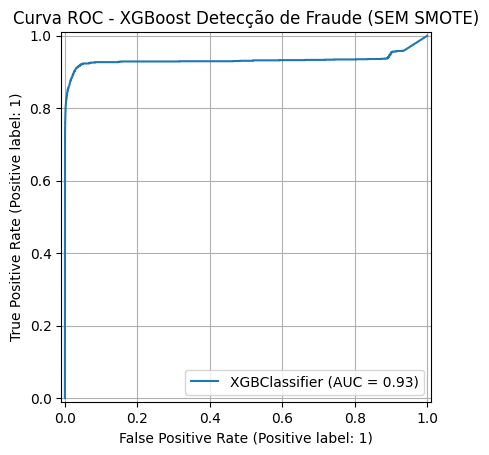

In [13]:
RocCurveDisplay.from_estimator(xgb_sem_smote, X_test, y_test)
plt.title("Curva ROC - XGBoost Detecção de Fraude (SEM SMOTE)")
plt.grid(True)
plt.show()

Aplicando SMOTE nos dados de treino

In [14]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Treinando o modelo XGBoost Classifier (COM SMOTE)

In [15]:
xgb_com_smote = XGBClassifier(n_estimators=100,random_state=42,eval_metric='logloss')
xgb_com_smote.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Realizando previsões (COM SMOTE)

In [16]:
y_proba_smote = xgb_com_smote.predict_proba(X_test)[:, 1]

Encontrando threshold ideal (baseado em F1-score)

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_smote)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

Aplicando threshold

In [18]:
y_pred_smote = (y_proba_smote > best_threshold).astype(int)

Avaliando desempenho do modelo (COM SMOTE)

In [19]:
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_smote))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_smote))
roc_auc_smote = roc_auc_score(y_test, y_proba_smote)
print(f"AUC-ROC (COM SMOTE): {roc_auc_smote:.4f}")

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.97      0.77      0.85      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.88      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

Matriz de Confusão:
[[1270862      42]
 [    379    1241]]
AUC-ROC (COM SMOTE): 0.9976


Visualização das previsões (COM SMOTE)

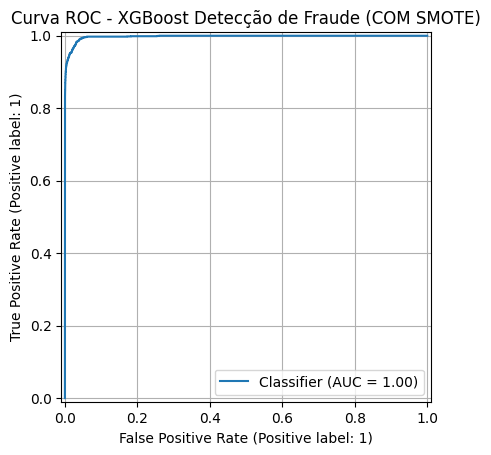

In [20]:
RocCurveDisplay.from_predictions(y_test, y_proba_smote)
plt.title("Curva ROC - XGBoost Detecção de Fraude (COM SMOTE)")
plt.grid(True)
plt.show()

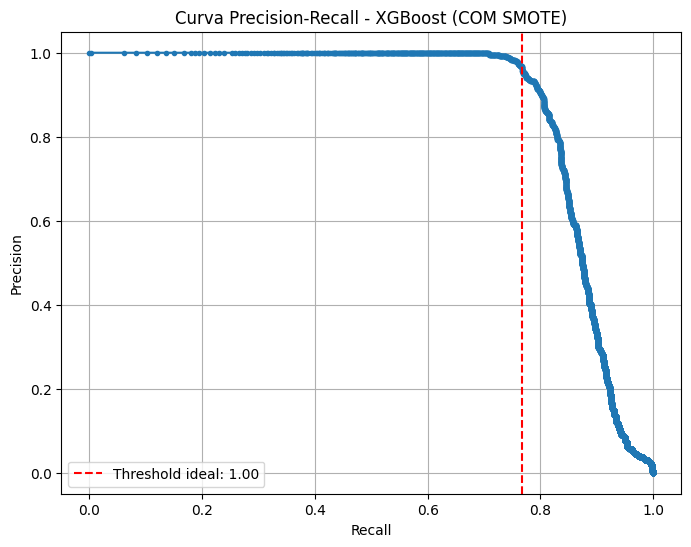

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axvline(recall[best_idx], color='r', linestyle='--', label=f'Threshold ideal: {best_threshold:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - XGBoost (COM SMOTE)")
plt.legend()
plt.grid(True)
plt.show()

Salvando o modelo e encoder com Pickle

In [22]:
with open('modelo_xgboost_fraude.pkl', 'wb') as file_model:
    pickle.dump(xgb_com_smote, file_model)

with open('label_encoder_type_fraude.pkl', 'wb') as file_encoder:
    pickle.dump(le_type, file_encoder)

print("Modelo XGBoost e Encoder para detecção de fraude salvos com sucesso!")

Modelo XGBoost e Encoder para detecção de fraude salvos com sucesso!
